# Logistische Regression (Demo)

# 1 - Imports und Funktionen

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import sklearn.datasets
import h5py
import scipy
from scipy import ndimage
from scipy.special import expit
from PIL import Image
import seaborn as sns

import pandas as pd
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline


In [3]:
# Logistische Regression vorhersage
def h(w, x):
    return expit(np.dot(w, x))

In [53]:
def plot_decision_boundary(ax, w, X, y, title=""):
    """Plot points, shaded regions, and decision boundary"""

    # Create mesh grid for shading
    x_min, x_max = X[:,0].min() - 0.1, X[:,0].max() + 0.1
    y_min, y_max = X[:,1].min() - 0.1, X[:,1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    # Compute linear combination z = w0 + w1*x + w2*y
    # For shading, we need to pass a 2D array representing the value at each point on the grid.
    # We add a bias term (1) to xx and yy to match the w vector [w0, w1, w2]
    # np.c_[np.ones(xx.ravel().shape[0]), xx.ravel(), yy.ravel()] creates a (N*N, 3) array
    # Z = np.dot(np.c_[np.ones(xx.ravel().shape[0]), xx.ravel(), yy.ravel()], w).reshape(xx.shape)
    # A simpler way given current w structure:
    Z = w[0] + w[1] * xx + w[2] * yy

    # Shade regions for logistic regression
    # Use sigmoid to get probabilities and a diverging colormap
    probabilities = expit(Z)

    cf = ax.contourf(xx, yy, probabilities, alpha=0.6, cmap='RdYlGn', levels=np.linspace(0,1,10))
    fig = ax.figure # Get the figure object from the axes
    cbar = fig.colorbar(cf, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label('Probability of Class 1') # Label for the color bar

    # Plot the decision boundary line (where Z = 0 or probability = 0.5)
    # For w0 + w1*x + w2*y = 0 → y = -(w0 + w1*x)/w2
    x_vals = np.linspace(x_min, x_max, 300)
    # Check if w[2] is close to zero to avoid division by zero
    if abs(w[2]) > 1e-6:
        y_vals = -(w[0] + w[1] * x_vals) / w[2]
        ax.plot(x_vals, y_vals, "b-", linewidth=2)
    else: # Handle vertical decision boundary case
        ax.axvline(-w[0]/w[1], color="b", linestyle="-", linewidth=2)

    # Plot dataset
    ax.scatter(X[y==1][:,0], X[y==1][:,1], color="green", edgecolors="k", label='1 (versicolor)')
    ax.scatter(X[y==0][:,0], X[y==0][:,1], color="red", edgecolors="k", label='0 (setosa)')

    ax.set_title(title)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.legend()


In [5]:
# Calculate y for (x,y) on the decision boundary
# w0 + w1*x + w2*y = 0   →   y = -(w0 + w1*x)/w2
def f(w, x):
  return -(w[0] + w[1] * x) / w[2]

# 2 - Datensatz

In [6]:
# Iris Datensatz laden
iris = load_iris()

In [7]:
print("Vier Merkmale:")
print(iris.feature_names)
print("\n")
print("3 Zielwerte (Klassen):")
print(iris.target_names)

Vier Merkmale:
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


3 Zielwerte (Klassen):
['setosa' 'versicolor' 'virginica']


In [8]:
# Nur die ersten zwei Klassen verwenden (für binäre Klassifikation)
X = iris.data[iris.target < 2]       # Merkmale
y = iris.target[iris.target < 2]     # Zielwerte

# Nur die ersten zwei Merkmale verwenden (damit 2D-visualisierbar)
X = X[:, [0, 1]]

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (100, 2)
Shape of y: (100,)


In [9]:
# Pandas DataFrame erstellen (für tabellarische Darstellung)
df = pd.DataFrame(X, columns=["x_1", "x_2"])
df['target'] = y

In [10]:
# Die ersten und letzten fünf Einträge im DataFrame in einer
# Tabelle anzeigen (head und tail konkatenieren)
df_headtail = pd.concat([df.head(5), df.tail(5)])
display(df_headtail)

,x_1,x_2,target
0,5.1,3.5,0
1,4.9,3.0,0
2,4.7,3.2,0
3,4.6,3.1,0
4,5.0,3.6,0
95,5.7,3.0,1
96,5.7,2.9,1
97,6.2,2.9,1
98,5.1,2.5,1
99,5.7,2.8,1


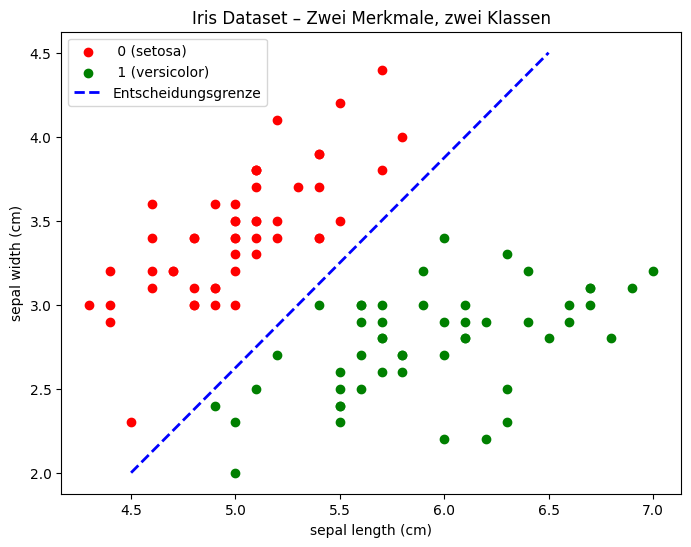

In [11]:
plt.figure(figsize=(8, 6))

plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', label=' 0 (setosa)')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='green', label=' 1 (versicolor)')

# Eine gute lineare Entscheidungsgrenze (Decision Boundary):
# Linie zwischen den Punkten (4.5, 2) und (6.5, 4.5).
plt.plot([4.5, 6.5], [2, 4.5], color='blue', linestyle='--', linewidth=2, label='Entscheidungsgrenze')

plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title("Iris Dataset – Zwei Merkmale, zwei Klassen")
plt.legend()
#plt.grid(True)
plt.show()

# 3 - Logistisches Regressionsmodell


In [12]:
# ----------------------------------------------------
# Bias-Term hinzufügen: X → [1, x1, x2]
# ----------------------------------------------------
Xb = np.hstack([np.ones((X.shape[0], 1)), X])
Xb = Xb.T                   # ein Datenpunkt pro Spalte (für die Konsistenz mit Folien)
yb = y.reshape(1, -1)       # ein Datenpunkt pro Spalte (für die Konsistenz mit Folien)
print(Xb.shape)
print(yb.shape)

(3, 100)
(1, 100)


In [13]:
# ----------------------------------------------------
# Gewichtsparameter zufällig initialisieren
# ----------------------------------------------------
#np.random.seed(42)
#w = np.random.rand(3)

# Für die Demo starten wir mit "netten" Werten
w = np.array([[-3.5], [1.5], [-1.3]])
print(w.shape)

(3, 1)


In [14]:
# Logistisches Regressionsmodell
def h(w, X):
  z=np.dot(w.T, X)
  a = expit(z)
  return a

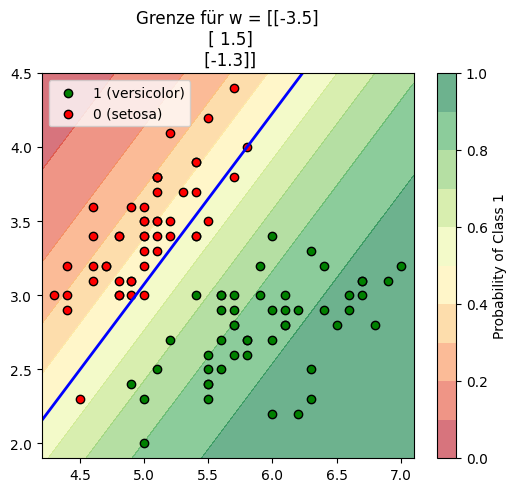

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot_decision_boundary(ax, w, X, y, title=f"Grenze für w = {w}")
plt.show()


In [16]:
# Vorhersagen
A = h(w, Xb)

In [17]:
df['pred'] = A.T
display(df.head(5))
print("\n...")
display(df.tail(5))

,x_1,x_2,target,pred
0,5.1,3.5,0,0.401312
1,4.9,3.0,0,0.487503
2,4.7,3.2,0,0.352059
3,4.6,3.1,0,0.347511
4,5.0,3.6,0,0.336261



...


,x_1,x_2,target,pred
95,5.7,3.0,1,0.759511
96,5.7,2.9,1,0.782450
97,6.2,2.9,1,0.883911
98,5.1,2.5,1,0.710950
99,5.7,2.8,1,0.803766


# 4 - Gradientenabstieg

## 4.1 Verlust (Loss)

In [18]:
# Binary Cross-Entropy
def loss(A, y):
  return -y * np.log(A) - (1 - y) * np.log(1 - A)

In [19]:
L = loss(A,yb)
print(L.shape)

(1, 100)


In [20]:
df['loss'] = L.T
display(df.head(7))

,x_1,x_2,target,pred,loss
0,5.1,3.5,0,0.401312,0.513015
1,4.9,3.0,0,0.487503,0.668460
2,4.7,3.2,0,0.352059,0.433956
3,4.6,3.1,0,0.347511,0.426960
4,5.0,3.6,0,0.336261,0.409867
5,5.4,3.9,0,0.384616,0.485509
6,4.6,3.4,0,0.265027,0.307922


## 4.2 Kosten

In [21]:
# Kosten (Durchschnittlicher Verlust)
m = y.shape[0]
J = (1/m) * np.sum(L, axis=1)
print(f"Kosten: {J}")

Kosten: [0.34382807]


## 4.3 Gradienten

In [22]:
dw0 = A - yb
dw1 = (A - yb) * Xb[1, :]
dw2 = (A - yb) * Xb[2, :]
print(dw0.shape)
print(dw1.shape)

(1, 100)
(1, 100)


In [23]:
df['dw0'] = dw0.T
df['dw1'] = dw1.T
df['dw2'] = dw2.T
display(df.head(7))

,x_1,x_2,target,pred,loss,dw0,dw1,dw2
0,5.1,3.5,0,0.401312,0.513015,0.401312,2.046693,1.404593
1,4.9,3.0,0,0.487503,0.668460,0.487503,2.388763,1.462508
2,4.7,3.2,0,0.352059,0.433956,0.352059,1.654678,1.126589
3,4.6,3.1,0,0.347511,0.426960,0.347511,1.598548,1.077283
4,5.0,3.6,0,0.336261,0.409867,0.336261,1.681307,1.210541
5,5.4,3.9,0,0.384616,0.485509,0.384616,2.076928,1.500003
6,4.6,3.4,0,0.265027,0.307922,0.265027,1.219126,0.901093


In [24]:
# Durchschnitt über alle dw-Werte
dw_0 = np.mean(dw0)
dw_1 = np.mean(dw1)
dw_2 = np.mean(dw2)
print(f"dw_0: {dw_0}")
print(f"dw_1: {dw_1}")
print(f"dw_2: {dw_2}")

dw_0: 0.11711530213917523
dw_1: 0.5356254651876057
dw_2: 0.44944121904521944


In [25]:
# Vektorisierte Berechnung über den gesamten Datensatz
dw = 1/m * np.dot(Xb, (A-yb).T)
print(dw)
print(dw.shape)     # dw muss die gleiche Form wie w haben

[[0.1171153 ]
 [0.53562547]
 [0.44944122]]
(3, 1)


## 4.2 Gewichtsaktualisierung

In [26]:
# Lernrate / Schrittweite
lr = 0.01

In [27]:
# Gewichte aktualisieren
w_new = w - lr * dw

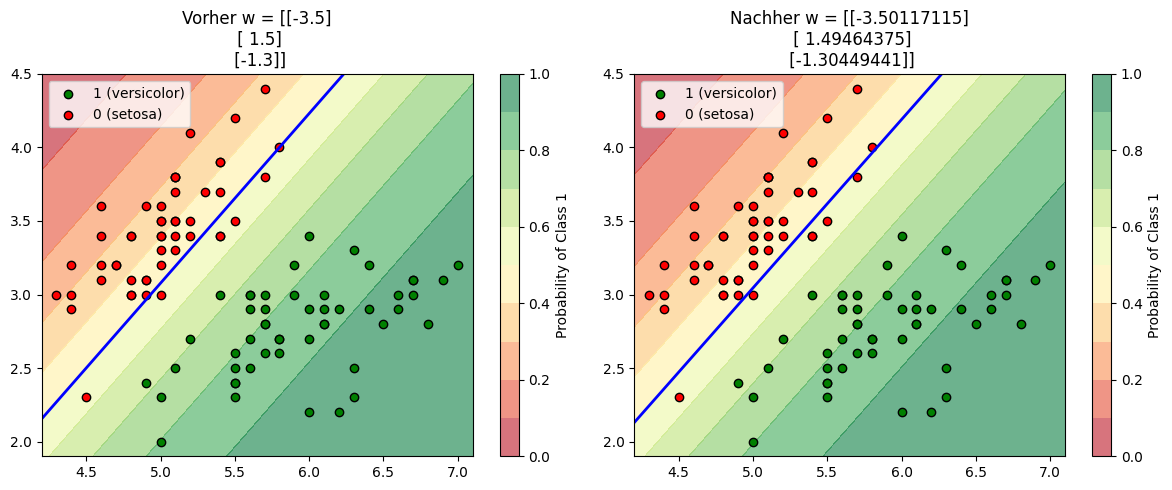

In [52]:
# ----------------------------------------------------
# PLOT vorher-nachher
# ----------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
t = f"Grenze für w = {w}"
plot_decision_boundary(ax[0], w,     X, y, title=f"Vorher w = {w}")
plot_decision_boundary(ax[1], w_new, X, y, title=f"Nachher w = {w_new}")

plt.tight_layout()
plt.show()

# 5 - Training des Modells

In [ ]:
# Parameter und Hyperparameter initialisieren
w = np.array([[-3.5], [1.5], [-1.3]])
lr = 0.00001

## Wiederholte Gewichtsaktualisierungen

* Beobachten Sie die Kosten!
* Experimentieren Sie mit unterschiedlichen Lernraten!


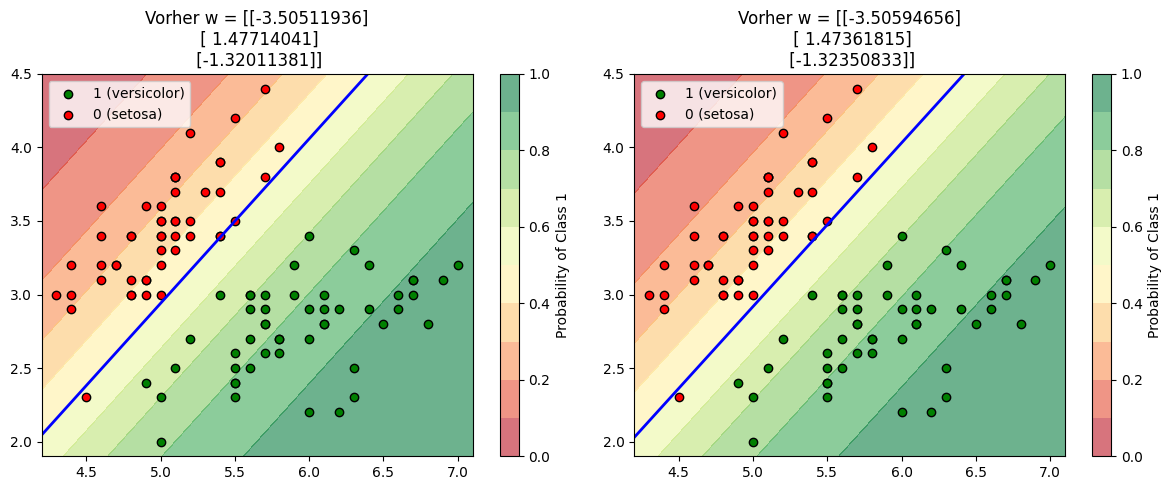

Kosten: [0.32522503]


In [45]:
# Loop: Diese Zelle wiederholt ausführen und generierten Plot beobachten
w = w_new

# ----------------------------------------------------
# 1. Vorhersagen und Kosten berechnen
# ----------------------------------------------------
A = h(w, Xb)
L = loss(A,yb)
J = (1/m) * np.sum(L, axis=1)

# ----------------------------------------------------
# 2. Gradient Berechnen
# ----------------------------------------------------
dw = 1/100 * np.dot(Xb, (A-yb).T)

# ------------------------------------------------------
# 3. Gewichtsaktualisierung
# ------------------------------------------------------
w_new = w - lr * dw

# ----------------------------------------------------
# PLOT vorher-nachher
# ----------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundary(ax[0], w,     X, y, title=f"Vorher w = {w}")
plot_decision_boundary(ax[1], w_new, X, y, title=f"Vorher w = {w_new}")

plt.tight_layout()
plt.show()
print(f"Kosten: {J}")

# 6 - Übung

In [ ]:
# 1. Wiederholen Sie das ganze mit vier Merkmalen
#    - h(x) = expit(w0 + w1*x1 + w2*x2 + w3*x3 + w4*x4)
#    - Visualisierung der Datenpunkte und der Entscheidungsgrenze in 4D nicht möglich
#    ----> Güte des Modells durch dessen Kosten J beobachten
#    ----> Kosten J über mehrere Epochen hinweg speichern und Kostenkurve plotten

In [ ]:
# 2. Wiederholen Sie das ganze mit batch_size=1 bzw. batch_size=10
#    - Speichern Sie die Kosten am Ende jeder Epoche, bzw. nach jeder Gewichstaktualisierung
#    - Plotten Sie am Ende des Trainings die Kostenkurve
#    - Vergleichen Sie die Kostenkurven zu der in Aufgabe 1.